In [2]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

# Machine learning libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc
from scipy import stats

In [2]:
SavePlots = True

In [3]:
# Import the data for testing and training from file
data = pd.read_csv('Data/earning_potential_train_test.txt') #think about earning column that is a string
data

,age,education,gender,hours-per-week,earning
0,39,13,0,40,<=50K
1,50,13,0,13,<=50K
2,38,9,0,40,<=50K
3,53,7,0,40,<=50K
4,28,13,1,40,<=50K
...,...,...,...,...,...
4495,50,13,0,40,>50K
4496,41,10,0,70,<=50K
4497,46,4,0,47,<=50K
4498,35,11,1,40,<=50K


In [4]:
# Import the data for the analysis
real_data = pd.read_csv('Data/earning_potential_real.txt')
real_data

,ID,age,education,gender,hours-per-week
0,0,40,9,1,40
1,1,28,13,1,48
2,2,49,10,1,30
3,3,32,9,0,40
4,4,33,9,0,40
...,...,...,...,...,...
3607,3607,46,11,1,63
3608,3608,47,10,1,40
3609,3609,74,9,1,40
3610,3610,55,10,0,40


# Building the Classifier Part

## Creating train/test data sets

In [5]:
# First we lets look at our data - how many of each classes are there?
N_high = np.sum( data['earning'] == ' >50K' )
N_low = np.sum( data['earning'] == ' <=50K' )
ratio = N_high / N_low

# Print results
print(f'There are {len(data)} individuals included in the full data set.')
print(f'Higher income earners: {N_high}')
print(f'Lower income earners: {N_low}')
print(f'If signal is high earners, and background is low earners, the signal to noise ratio is: {ratio:.2f}')

There are 4500 individuals included in the full data set.
Higher income earners: 1091
Lower income earners: 3409
If signal is high earners, and background is low earners, the signal to noise ratio is: 0.32


Since our data set is not balanced, we want this to be reflected in both the training and the testing data set we create.

In [6]:
# Lets split the data into high and low earners
high_mask = (data['earning'] == ' >50K')
low_mask = (data['earning'] == ' <=50K')

# X contains the parameters - should have shape (samples, parameters)
X_high = data.iloc[:, :4][high_mask] #iloc extracts columns age, education, gender and h/week
X_low = data.iloc[:, :4][~high_mask]

# Y contains the labels (high earners=1, and low-earners=0) - shape (samples)
Y_high = np.ones(N_high)
Y_low = np.zeros(N_low)

# Define random splitting seed
seed = 1

# Define test size (we will try 54/46 - ensures that there are 500 high earners in the test)
test_sz = 0.46

# Now we split high earners and low earners individually
X_high_train, X_high_test, Y_high_train, Y_high_test = train_test_split(X_high, Y_high, test_size=test_sz, 
                                                                        random_state=seed)
X_low_train, X_low_test, Y_low_train, Y_low_test = train_test_split(X_low, Y_low, test_size=test_sz, 
                                                                        random_state=seed)

# Print some stats so we know we get what we want
print('\t\t\t TEST \t\t\t TRAIN')
print('--------------------------------------------------------------')
print(f'TOTAL: \t\t\t {len(X_high_test)+len(X_low_test)} \t\t\t {len(X_high_train)+len(X_low_train)}')
print(f'HIGH EARNERS: \t\t {len(X_high_test)} \t\t\t {len(X_high_train)}')
print(f'LOW EARNERS: \t\t {len(X_low_test)} \t\t\t {len(X_low_train)}')
print(f'S/N RATIO: \t\t {len(X_high_test)/len(X_low_test):.2f} \t\t\t {len(X_high_train)/len(X_low_train):.2f}')

			 TEST 			 TRAIN
--------------------------------------------------------------
TOTAL: 			 2071 			 2429
HIGH EARNERS: 		 502 			 589
LOW EARNERS: 		 1569 			 1840
S/N RATIO: 		 0.32 			 0.32


In [7]:
# Concatenate the results
X_train = np.vstack([X_high_train, X_low_train])
Y_train = np.hstack([Y_high_train, Y_low_train])

X_test = np.vstack([X_high_test, X_low_test])
Y_test = np.hstack([Y_high_test, Y_low_test])

# Shuffle the results so they are not ordered so highest earners are first
perm_train = np.random.permutation(len(X_train))
X_train = X_train[perm_train]
Y_train = Y_train[perm_train]

perm_test = np.random.permutation(len(X_test))
X_test = X_train[perm_test]
Y_test = Y_train[perm_test]

# Check shapes
np.shape(X_train), np.shape(Y_train), np.shape(X_test), np.shape(Y_test)

((2429, 4), (2429,), (2071, 4), (2071,))

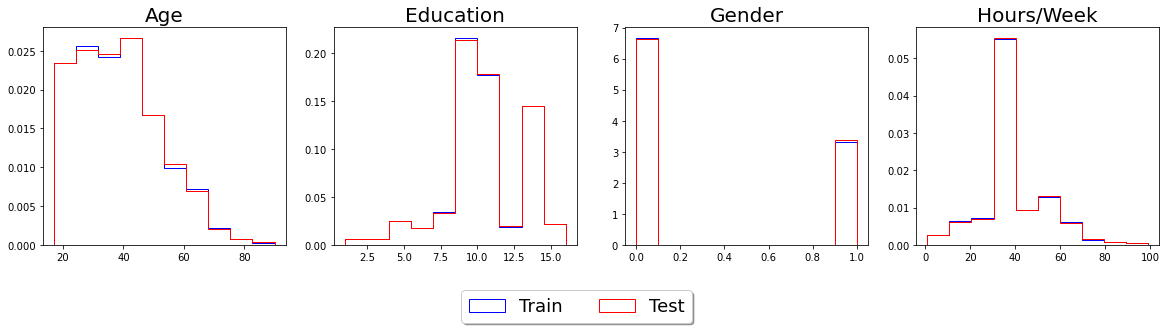

In [8]:
# Lets check that the test sample explores the whole parameter space by making histograms
fig, ax = plt.subplots(ncols=4, figsize=(20,4))

# Age ---------
ax[0].set_title('Age', fontsize=20)
ax[0].hist(X_train[:,0], color='blue', histtype='step', density=True)
ax[0].hist(X_test[:,0], color='red', histtype='step', density=True)

# Education ---------
ax[1].set_title('Education', fontsize=20)
ax[1].hist(X_train[:,1], color='blue', histtype='step', density=True, label='Train')
ax[1].hist(X_test[:,1], color='red', histtype='step', density=True, label='Test')

# Gender ---------
ax[2].set_title('Gender', fontsize=20)
ax[2].hist(X_train[:,2], color='blue', histtype='step', density=True)
ax[2].hist(X_test[:,2], color='red', histtype='step', density=True)

# Hours per week ---------
ax[3].set_title('Hours/Week', fontsize=20)
ax[3].hist(X_train[:,3], color='blue', histtype='step', density=True)
ax[3].hist(X_test[:,3], color='red', histtype='step', density=True)


ax[1].legend(loc='lower center', bbox_to_anchor=(1, -0.4), ncol=3, fancybox=True, shadow=True, fontsize=18)

if SavePlots: plt.savefig('Plots/1_check_train_test.png')
plt.show()

## Selecting hyperparameters

In [1]:
# The main parameters are max_depth and n_estimators so lets make a gridsearch of variations those

# Define model
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                      learning_rate=0.1, use_label_encoder=False)

# Specify parameters and distributions to sample from
parameters_RandomSearch = {'max_depth': stats.randint(1,10), 
                           'n_estimators': stats.randint(1, 200)}

# Chose number of iterations and number of folds
n_iter_search = 5
k = 3

RandomSearch = RandomizedSearchCV(model, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=k, 
                                  return_train_score=True,
                                  random_state=1,
                                  scoring = 'accuracy')
# Fit the random search instance
RandomSearch.fit(X_train, Y_train);

# Get results
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

RandomSearch_results.head(3)

NameError: name 'XGBClassifier' is not defined

In [10]:
### New random search close to the best point ###

# Specify parameters and distributions to sample from (center around the best values from previous search)
xlim2 = (1,5)
ylim2 = (1,150)
parameters_RandomSearch2 = {'max_depth': stats.randint(1,5), 
                           'n_estimators': stats.randint(1,150) }

# Chose number of iterations and number of folds
n_iter_search = 20
k = 3

RandomSearch2 = RandomizedSearchCV(model, 
                                   param_distributions=parameters_RandomSearch2, 
                                   n_iter=n_iter_search, 
                                   cv=k, 
                                   return_train_score=True,
                                   random_state=2,
                                   scoring = 'balanced_accuracy')

# Fit the random search instance
RandomSearch2.fit(X_train, Y_train);

# Get results
RandomSearch2_results = pd.DataFrame(RandomSearch2.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch2.best_params_, f", Best scores: {RandomSearch2.best_score_:.3f}")

RandomSearch2_results.head(3)

Random Search: 	Best parameters:  {'max_depth': 4, 'n_estimators': 122} , Best scores: 0.670


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.021329,0.003160,0.002737,0.000212,1,16,"{'max_depth': 1, 'n_estimators': 16}",0.500000,0.500000,0.500000,0.500000,0.000000,19,0.500000,0.500000,0.500000,0.500000,0.000000
1,0.078174,0.041234,0.003640,0.001242,2,73,"{'max_depth': 2, 'n_estimators': 73}",0.671999,0.643680,0.647576,0.654418,0.012532,15,0.655425,0.682696,0.691577,0.676566,0.015382
2,0.037232,0.002483,0.002777,0.000552,3,44,"{'max_depth': 3, 'n_estimators': 44}",0.683125,0.643772,0.645841,0.657579,0.018083,11,0.657154,0.684025,0.695036,0.678738,0.015911


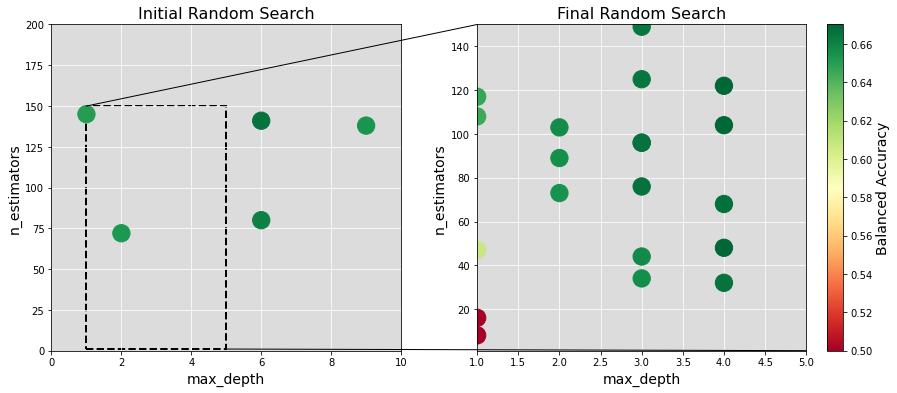

In [11]:
# Lets try to plot it with colors in a 2d parameter space ----------------------------------

# Create figure
fig, ax = plt.subplots(ncols=2, figsize=(15,6), gridspec_kw={'wspace':0.2, 'width_ratios':(1.7,2)})

# Get parameters
x1 = RandomSearch_results['param_max_depth']
x2 = RandomSearch_results['param_n_estimators']
color = RandomSearch_results['mean_test_score']

x1_2 = RandomSearch2_results['param_max_depth']
x2_2 = RandomSearch2_results['param_n_estimators']
color2 = RandomSearch2_results['mean_test_score']

mini, maxi = np.min(np.concatenate((color,color2))), np.max(np.concatenate((color,color2))) #color ranges

# Plot initial random search
ax[0].scatter(x1, x2, s=300, c = color, cmap='RdYlGn', zorder=2, vmin=mini, vmax=maxi)
ax[0].set_facecolor('gainsboro')
ax[0].grid(color='w', zorder=0)
ax[0].set_xlabel('max_depth', fontsize=14)
ax[0].set_ylabel('n_estimators', fontsize=14)
ax[0].set_title('Initial Random Search', fontsize=16)
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,200)

# Plot final search
im2 = ax[1].scatter(x1_2, x2_2, s=300, c = color2, cmap='RdYlGn', zorder=2, vmin=mini, vmax=maxi)
ax[1].set_facecolor('gainsboro')
ax[1].grid(color='w', zorder=0)
ax[1].set_xlabel('max_depth', fontsize=14)
ax[1].set_ylabel('n_estimators', fontsize=14)
ax[1].set_title('Final Random Search', fontsize=16)
ax[1].set_xlim(*xlim2)
ax[1].set_ylim(*ylim2)

# Shared colorbar
cbar = fig.colorbar(im2, ax=ax[1])
cbar.set_label('Balanced Accuracy', fontsize=14, x=1.7)

# Mark the zoom in plot ------------------------
# Square (x,y,width,height)
rect = patches.Rectangle((xlim2[0],ylim2[0]), xlim2[1]-xlim2[0], ylim2[1]-ylim2[0], linewidth=2, edgecolor='k', facecolor='none', linestyle='dashed')
ax[0].add_patch(rect)
# Lines
line1 = patches.ConnectionPatch(xyA=(xlim2[0],ylim2[1]), xyB=(xlim2[0],ylim2[1]), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line1)
line2 = patches.ConnectionPatch(xyA=(xlim2[1],ylim2[0]), xyB=(xlim2[1],ylim2[0]), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line2)

plt.savefig('Plots/1_randomsearch.png')

plt.show()

In [12]:
# Set the hyperparameters found
max_depth_RS = RandomSearch2.best_params_['max_depth']
n_estimators_RS = RandomSearch2.best_params_['n_estimators']

## Constructing the classifier

In [13]:
# Define model
model_RS = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                      learning_rate=0.1, use_label_encoder=False, n_estimators=n_estimators_RS, 
                      max_depth=max_depth_RS)

# Train model on train set
model_RS.fit(X_train, Y_train)

# Calculate balanced accuracy score
Y_pred_RS = model_RS.predict(X_test)
accuracy_RS = balanced_accuracy_score(Y_test, Y_pred_RS)
print('Balanced accuracy:', accuracy_RS)

# Get predictions
#a numpy array of shape array-like of shape (n_samples, n_classes) 
# with the probability of each data example being of a given class.
predictions_RS = model_RS.predict_proba(X_test) 
predictions_RS = pd.DataFrame(predictions_RS, columns=['low earner', 'high earner'])

Balanced accuracy: 0.7121395143890358


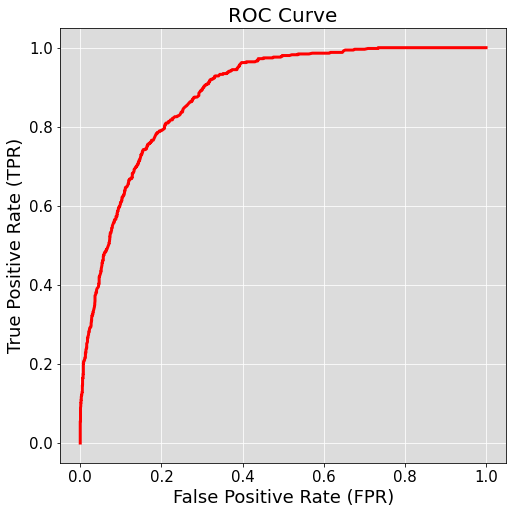

In [14]:
# Get fpr and tpr to produce roc_curve
fpr_RS, tpr_RS, _ = roc_curve(Y_test, predictions_RS['high earner'])
auc_score_RS = auc(fpr_RS, tpr_RS)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr_RS, tpr_RS, color='r', linewidth=3)

ax.set_facecolor('gainsboro')
ax.grid(color='white')

ax.set_xlabel('False Positive Rate (FPR)', fontsize=18)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=18)
ax.set_title('ROC Curve', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('Plots/1_ROC.png')

plt.show()

## Selecting the cut with 85 precision

In [15]:
# Define precision wanted
precision_want = 0.85

# Predictions on test sample (we will chose the cut from train)
predictions_RS_train = model_RS.predict_proba(X_train) 
predictions_RS_train = pd.DataFrame(predictions_RS_train, columns=['low earner', 'high earner'])

In [16]:
def compute_precision(prob_high_arr, cut, true_labels):
    
    # Array to put classifications in, all start as low earner
    pred = np.zeros(len(prob_high_arr))
    
    # Make a mask saying when the probability is above the cut and it should be classified as high earner
    high_earners_mask = (prob_high_arr > cut)
    
    # Make classifications
    pred[high_earners_mask] = 1
    
    # Return the precision
    return precision_score(y_true=true_labels, y_pred=pred)

In [17]:
# Different values to test of cut
cut_arr = np.linspace(0,0.93,100)

# Array to store precision
precision_arr = np.zeros(100)

for i in range(len(cut_arr)):
    
    precision_arr[i] = compute_precision(predictions_RS_train['high earner'], cut_arr[i], Y_train)
    
# Chose precision at 85%
idx_cut = np.argmin(abs(precision_arr - precision_want))
cut_arr[idx_cut], precision_arr[idx_cut]

(0.6763636363636364, 0.8589743589743589)

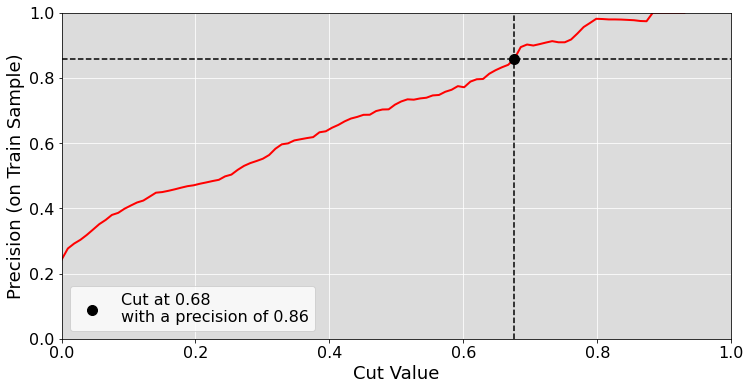

In [18]:
# Plot choice of cut
fig, ax = plt.subplots(figsize=(12,6))

ax.set_facecolor('gainsboro')
ax.grid(color='white')

ax.plot(cut_arr, precision_arr, color='r', linewidth=2)

ax.scatter(cut_arr[idx_cut], precision_arr[idx_cut], color='k', s=100, zorder=3,
           label=f'Cut at {cut_arr[idx_cut]:.2f} \nwith a precision of {precision_arr[idx_cut]:.2f}')
ax.hlines(precision_arr[idx_cut], 0, 1, linestyle='dashed', color='k')
ax.vlines(cut_arr[idx_cut], 0, 1, linestyle='dashed', color='k')

ax.legend(prop={'size':16}, loc='lower left')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Cut Value', fontsize=18)
ax.set_ylabel('Precision (on Train Sample)', fontsize=18)

plt.savefig('Plots/1a_cut.png')
plt.show()

In [19]:
# Calculate the precision on the test set with the given cut
precision_test = compute_precision(predictions_RS['high earner'], cut_arr[idx_cut], Y_test)
precision_test

0.8473282442748091

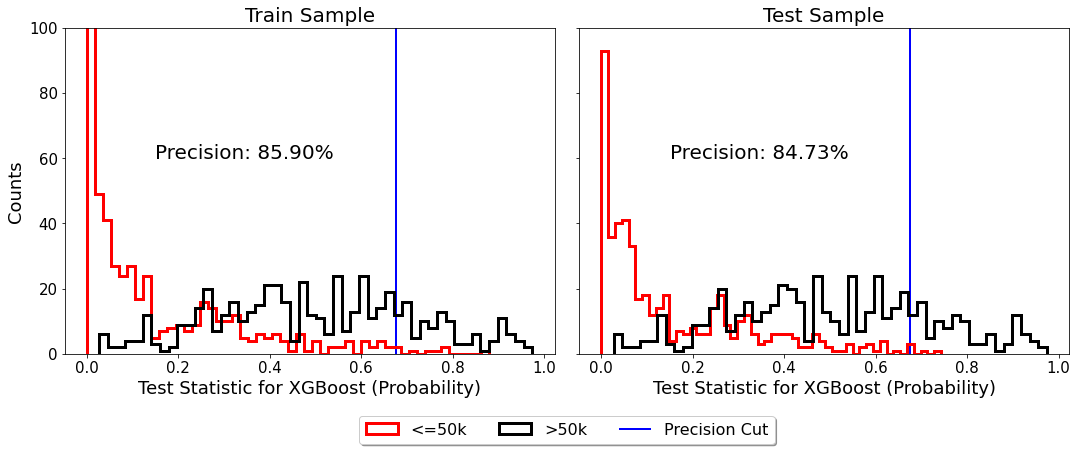

In [22]:
# Create test statistic plot
fig, ax = plt.subplots(ncols=2, figsize=(18,6), sharey=True, gridspec_kw={'wspace':0.05})

# Train sample ---------
ax[0].hist(predictions_RS_train['high earner'][Y_train==0][:500], color='r', histtype='step', 
           bins=50, linewidth=3, label='<=50k')
ax[0].hist(predictions_RS_train['high earner'][Y_train==1][:500], color='k', histtype='step', 
           bins=50, linewidth=3, label='>50k')

# Mark cut
ax[0].vlines(cut_arr[idx_cut], 0, 100, linewidth=2, color='blue', zorder=2, label='Precision Cut')
ax[0].set_ylim(0,100)

# Write precision
ax[0].text(0.15, 60,f'Precision: {precision_arr[idx_cut]*100:.2f}%', fontsize=20)

ax[0].tick_params(axis="x", labelsize=15) 
ax[0].tick_params(axis="y", labelsize=15) 
ax[0].set_ylabel('Counts', fontsize=18)
ax[0].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[0].set_title('Train Sample', fontsize=20)


# Test sample ---------
ax[1].hist(predictions_RS['high earner'][Y_test==0][:500], color='r', histtype='step', 
           bins=50, linewidth=3, label='<=50k')
ax[1].hist(predictions_RS['high earner'][Y_test==1][:500], color='k', histtype='step', 
           bins=50, linewidth=3, label='>50k')

# Mark cut
ax[1].vlines(cut_arr[idx_cut], 0, 100, linewidth=2, color='b', zorder=2, label='Precision Cut')
ax[1].set_ylim(0,100)


# write precision
ax[1].text(0.15, 60,f'Precision: {precision_test*100:.2f}%', fontsize=20)

ax[1].legend(loc='lower center', prop={'size':16}, bbox_to_anchor=(-0.025, -0.3),
          ncol=3, fancybox=True, shadow=True)

ax[1].tick_params(axis="x", labelsize=15) 
ax[1].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[1].set_title('Test Sample', fontsize=20)

plt.savefig('Plots/1a_hist.png')

plt.show()

# Problem 1B

In [21]:
model_RS.feature_importances_

array([0.2391265 , 0.30919608, 0.3369476 , 0.11472986], dtype=float32)

# Problem 1C

In [27]:
# Extract only the parameters to make X_val (n_samples, n_parameters)
X_val = real_data.iloc[:, 1:] #removes ID column

# Extract ID's for good measure
ID_val = real_data.iloc[:,0]

In [33]:
cut_arr[idx_cut]

0.6763636363636364

In [35]:
# Get the test statistic
predictions_RS_val = model_RS.predict_proba(X_val) 
predictions_RS_val = pd.DataFrame(predictions_RS_val, columns=['low earner', 'high earner'])

# Make predictions -----------

# Array to put classifications in, all start as low earner
pred_val = np.zeros(len(X_val))
    
# Make a mask saying when the probability is above the cut and it should be classified as high earner
high_earners_mask = (predictions_RS_val['high earner'] > cut_arr[idx_cut])
    
# Make classifications
pred_val[high_earners_mask] = 1

In [45]:
# Check how many there are of each
print(f'Model found {np.sum(high_earners_mask)} high income earners')
print(f'Model found {np.sum(~high_earners_mask)} high income earners')
print(f'Total number of individuals = {np.sum(high_earners_mask)+np.sum(~high_earners_mask)}')

print(f'Len of real data: {len(real_data)}')

Model found 203 high income earners
Model found 3409 high income earners
Total number of individuals = 3612
Len of real data: 3612


In [49]:
203/3409

0.059548254620123205

In [48]:
# Create the output file for high
with open('Data/Kimi_Kreilgaard.high_ID.txt', 'w') as f:
    for line in ID_val[high_earners_mask]:
        line = str(line)
        f.write(line)
        f.write('\n')
        
# Create the output file for low
with open('Data/Kimi_Kreilgaard.low_ID.txt', 'w') as f:
    for line in ID_val[~high_earners_mask]:
        line = str(line)
        f.write(line)
        f.write('\n')